# Step 1: Import Required Dependencies

# Step 2: Configure Directories

In [5]:
# Setup directories
TRAIN_DIR = 'train'
TEST_DIR = 'test'
FALSE_DIR = 'false'
TRUE_DIR = 'true'

# Make the directories
os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(TEST_DIR, exist_ok=True)

# Make test and train directories
os.makedirs(os.path.join(TRAIN_DIR, FALSE_DIR), exist_ok=True)
os.makedirs(os.path.join(TRAIN_DIR, TRUE_DIR), exist_ok=True)

os.makedirs(os.path.join(TEST_DIR, FALSE_DIR), exist_ok=True)
os.makedirs(os.path.join(TEST_DIR, TRUE_DIR), exist_ok=True)

# Step 3: Configure LFW Data

Move lfw data into one folder

In [5]:
LFW_DIR = 'lfw'

# Path to the 'lfw_mixed' directory where all images will be moved
lfw_mixed_dir = 'lfw_mixed'

# Create 'lfw_mixed' directory if it doesn't exist
os.makedirs(lfw_mixed_dir, exist_ok=True)

# Recursively traverse the 'lfw' directory and move all images to 'lfw_mixed'
for root, _, files in os.walk(LFW_DIR):
    for file in files:
        if file.lower().endswith(('.jpg')):
            src = os.path.join(root, file)
            dst = os.path.join(lfw_mixed_dir, file)
            shutil.copy2(src, dst)


Split into test and train directories

In [6]:
train_ratio = 0.8

images = os.listdir(lfw_mixed_dir)
random.shuffle(images)

#num_train = int(len(images) * train_ratio)
num_train = 1500

train_images = images[:num_train]
test_images = images[num_train:2*num_train]

counter = 1

for image in train_images:
    src = os.path.join(lfw_mixed_dir, image)
    dst = os.path.join(TRAIN_DIR, FALSE_DIR, str(counter) + '.jpg')
    counter += 1
    shutil.copyfile(src, dst)
    
counter = 1

for image in test_images:
    src = os.path.join(lfw_mixed_dir, image)
    dst = os.path.join(TEST_DIR, FALSE_DIR, str(counter) + '.jpg')
    counter += 1
    shutil.copyfile(src, dst)

# Step 4: Configure Shaq Data

Define Shaq directories

In [6]:
SHAQ_DIR = 'shaq'
SHAQ_CROPPED_DIR = 'shaq_cropped'

os.makedirs(SHAQ_CROPPED_DIR, exist_ok=True)

Define align and cropping algorithm

In [2]:
# Initialize the Dlib face detector and shape predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# Function to detect and align faces in an image with a specified padding
def align_and_crop_face(image_path, output_path, padding=0):
    
    # Load the image
    image = cv2.imread(image_path)

    # Convert the image to grayscale for face detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Detect faces in the image
    faces = detector(gray)
    
    # Check if a face is detected
    if len(faces) > 0:
        # Assume there's only one face in the image for simplicity
        face = faces[0]

        # Get the facial landmarks for face alignment
        shape = predictor(gray, face)

        # Define the coordinates for the eyes
        left_eye = shape.part(36)  # Left eye
        right_eye = shape.part(45)  # Right eye

        # Calculate the angle for rotation (to make eyes horizontal)
        angle = np.arctan2(right_eye.y - left_eye.y, right_eye.x - left_eye.x)
        angle = np.degrees(angle)

        # Calculate new coordinates for cropping with padding
        x = max(0, face.left() - padding)
        y = max(0, face.top() - padding)
        w = min(image.shape[1], face.right() + padding) - x
        h = min(image.shape[0], face.bottom() + padding) - y

        # Crop the image with the new coordinates
        cropped_face = image[y:y+h, x:x+w]

        # Check if the cropped face is not empty
        if not cropped_face.size == 0:
            # Save the aligned and cropped face
            cv2.imwrite(output_path, cropped_face)
        else:
           # failed_to_crop += 1
           pass
    else:
        #no_face_detected += 1
        pass

Align and crop images

In [47]:
for image in os.listdir(SHAQ_DIR):
    image_path = os.path.join(SHAQ_DIR, image)
    output_path = os.path.join(SHAQ_CROPPED_DIR, image)
    
    try:
        align_and_crop_face(image_path, output_path, padding=50)
        
    except:
        pass

After executing this cell, manually prune non-shaq images from the cropped dir. It is a long process but we need all the shaq images we can get, regardless of whether they include other people.

Augment shaq images to get enough for training

In [48]:
# Create an ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=10,        # Random rotation by up to 40 degrees
    width_shift_range=0.1,   # Random horizontal shift by up to 20% of the width
    height_shift_range=0.1,  # Random vertical shift by up to 20% of the height
    shear_range=0.2,         # Shear transformations
    zoom_range=0.2,          # Random zoom in/out by up to 20%
    horizontal_flip=True,    # Random horizontal flip
    brightness_range=[0.2,1.0],
    fill_mode='nearest'      # Fill empty areas after transformations
)

# Create the output directory if it doesn't exist
output_directory = 'shaq_augmented'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# List all "shaq" image files in the directory
shaq_image_files = [os.path.join(SHAQ_CROPPED_DIR, filename) for filename in os.listdir(SHAQ_CROPPED_DIR)]

# Specify the number of augmentations per image
n_augmentations = 5  # You can adjust this number as needed

# Apply augmentation to each "shaq" image and save the augmented images
for image_path in shaq_image_files:
    
    try:
        img = load_img(image_path)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)  # Reshape for flow method

        i = 0
        for batch in datagen.flow(x, batch_size=1):
            augmented_image = array_to_img(batch[0])
            filename = os.path.basename(image_path)
            augmented_image.save(os.path.join(output_directory, f'augmented_{i}_{filename}'))
            i += 1
            if i >= n_augmentations:
                break
    except:
        pass


Sort into test and train directories

In [16]:
images = os.listdir(output_directory)
random.shuffle(images)

num_train = int(len(images) * train_ratio)

train_images = images[:num_train]
test_images = images[num_train:]

counter = 1

for image in train_images:
    src = os.path.join(output_directory, image)
    dst = os.path.join(TRAIN_DIR, TRUE_DIR, str(counter) + '.jpg')
    counter += 1
    shutil.copyfile(src, dst)
    
counter = 1

for image in test_images:
    src = os.path.join(output_directory, image)
    dst = os.path.join(TEST_DIR, TRUE_DIR, str(counter) + '.jpg')
    counter += 1
    shutil.copyfile(src, dst)
    
    

# Step 5: Import Data into Keras

Define training variables

In [3]:
IMG_SIZE=64
ROWS = 256
COLS = 256
CHANNELS = 3
batch_size= 64
Data_dir = 'train'
Test_DIR = 'test'

Import data into keras

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  Data_dir,
  validation_split=0.2, 
  subset="training", 
  seed=123,
  image_size=(ROWS, COLS),
  batch_size=batch_size)

Found 2672 files belonging to 2 classes.
Using 2138 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  Data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(ROWS, COLS),
  batch_size=batch_size)

Found 2672 files belonging to 2 classes.
Using 534 files for validation.


# Step 6: Configure CNN

Define training variables

In [14]:
num_classes = 2
epochs = 50

Define base model for transfer learning

In [15]:
base_model = keras.applications.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(256, 256, 3)
)


Freeze the weights and biases of the base model

In [16]:
for layer in base_model.layers:
    layer.trainable = False

Add additional dense layers for the shaq detection activity

In [17]:
model = keras.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Optional dropout layer to reduce overfitting
    layers.Dense(2, activation='softmax')  # Output layer for binary classification
])


Compile model

In [18]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Step 7: Training

Define callback function and train model

In [19]:
# callback function to monitor the loss and stop training if loss does not decrease for 5 consecutive epochs

callback =tf.keras.callbacks.EarlyStopping(
  monitor='val_loss', min_delta=0.0000001, patience=5)

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
    callbacks=[callback]
)

Epoch 1/50
34/34 [==============================] - 272s 8s/step - loss: 2.8559 - accuracy: 0.8957 - val_loss: 0.1755 - val_accuracy: 0.9757
Epoch 2/50
34/34 [==============================] - 263s 8s/step - loss: 0.0925 - accuracy: 0.9818 - val_loss: 0.0316 - val_accuracy: 0.9813
Epoch 3/50
34/34 [==============================] - 261s 8s/step - loss: 0.0316 - accuracy: 0.9864 - val_loss: 0.0305 - val_accuracy: 0.9888
Epoch 4/50
34/34 [==============================] - 258s 8s/step - loss: 0.0134 - accuracy: 0.9953 - val_loss: 0.0318 - val_accuracy: 0.9850
Epoch 5/50
34/34 [==============================] - 255s 8s/step - loss: 0.0172 - accuracy: 0.9930 - val_loss: 0.0242 - val_accuracy: 0.9906
Epoch 6/50
34/34 [==============================] - 255s 8s/step - loss: 0.0244 - accuracy: 0.9953 - val_loss: 0.0367 - val_accuracy: 0.9869
Epoch 7/50
34/34 [==============================] - 255s 8s/step - loss: 0.0093 - accuracy: 0.9953 - val_loss: 0.0290 - val_accuracy: 0.9925
Epoch 8/50
34

Save model

In [20]:
model.save('savedmodel') # savedmodel

INFO:tensorflow:Assets written to: shaq-detector_final/assets


INFO:tensorflow:Assets written to: shaq-detector_final/assets


View model training history

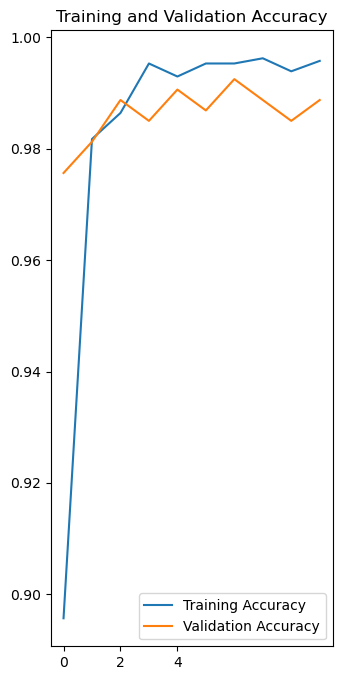

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

epochs = 5

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot( val_acc, label='Validation Accuracy')
plt.xticks(range(0,epochs)[0::2])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

# Step 8: Testing

Load testing data into keras

In [22]:
#images for Testing
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  Test_DIR,
  validation_split=0.0,
  seed=123,
  image_size=(ROWS, COLS),
  batch_size=batch_size)


Found 662 files belonging to 2 classes.


Test the model 

In [23]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.2%}")
print(f"Test Loss: {test_loss:.4f}")

11/11 [==============================] - 66s 6s/step - loss: 0.0279 - accuracy: 0.9924
Test Accuracy: 99.24%
Test Loss: 0.0279


Determine accuracy of each class

In [24]:
# Calculate predictions on the test data
y_true = []  # True labels
y_pred = []  # Predicted labels

for images, labels in test_ds:
    y_true.extend(labels.numpy())
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))

1/1 [==============================] - 2s 2s/step


In [25]:
# Calculate accuracy by age range/class
class_accuracies = []
for class_label in range(num_classes):
    correct = sum(y_true[i] == class_label and y_pred[i] == class_label for i in range(len(y_true)))
    total_samples = sum(y_true[i] == class_label for i in range(len(y_true)))
    class_accuracy = correct / total_samples if total_samples > 0 else 0.0  # Avoid division by zero
    class_accuracies.append(class_accuracy)
    print(f"Accuracy for Class {class_label}: {class_accuracy:.2%}")


Accuracy for Class 0: 99.74%
Accuracy for Class 1: 98.59%
